# Taylor Swift Lyric Generation with RNN-LSTM

## Instructions

Run the cells in sequential order 

The data link to dataset - https://www.kaggle.com/datasets/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums

The Taylor Swift Song Lyrics dataset on Kaggle is a collection of song lyrics from all of Taylor Swift's albums, including her debut album released in 2006 up to her latest album at the time of the dataset creation. The dataset includes lyrics from all of the songs on each album, including deluxe editions and bonus tracks. The dataset is provided in CSV format and includes columns for the album, song name, lyrics, and the year of release. It is intended to be used for natural language processing tasks, such as training language models or sentiment analysis, or for exploring patterns and trends in Taylor Swift's songwriting over time.

Here, we train a RNN-LSTM model. We train the model on this dataset and generate sentences which are then checked for quality.

Steps performed -

1) Dataset parsing

2) Tokenization, removal of special charactors, <s> </s> addition, /n addition

3) Corpus generation which is fed for training

4) Creating a RNN-LSTM model and training while monitoring accuracy

5) Generation

6) Perplexity calculation

## To get started
Download the dataset and put it in `Dataset/taylorswift` folder.

Run the cells

----------------------------------------
Contributed by - Samanvya Tripathi

# Import Libraries

In [2]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from tensorflow import keras
from __future__ import print_function
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding

stopwords = nltk.corpus.stopwords.words('english')
sns.set_palette(sns.color_palette('tab20', 20))    

# Build the Language Model

In [3]:
from itertools import islice
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

class LanguageModelRNN:
    def __init__(self, MIN_FREQUENCY=3, MIN_SEQ=5, BATCH_SIZE=32):
        """
        init function to define all the variables
        Paramters:
        MIN_FREQUENCY: The frequency of tokens below which the tokens are ignored
        MIN_SEQ: Number of words per sentence to be generated
        BATCH_SIZE: Batch size for training the model
        """
        self.MIN_FREQUENCY = MIN_FREQUENCY
        self.MIN_SEQ = MIN_SEQ
        self.BATCH_SIZE =  BATCH_SIZE
        
        self.data_train = []
        self.lyric_dic = {}
        self.lyric_dic_processed = {}
        
        self.text_as_list = []
        self.frequencies = {}
        self.uncommon_words = set()
        self.words = set()
        self.word_count = 0
        self.valid_seqs = []
        self.end_seq_words = []
        self.num_words = 0
        self.word_indices = {}
        self.indices_word = {}
        
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        
        self.examples_file = ""
        self.model = ""
        self.history = ""
    
    def load_dataset(self, link_to_dataset_train):
        """Load the dataset into class variable
        Parameters:
          link_to_dataset_train: the path where the dataset is present
        """
        # Dataset loading
        self.data_train = pd.read_csv(link_to_dataset_train, encoding='windows-1252')
        print(self.data_train.head(20))
        
    def dataset_parsing(self):
        """cleaning the data and making it usefull for the model
        Apply processing, adding to <s> </s> and /n to last words of every sentence
        """
        # Parsing dataset and organising
        lyric_dic = {} # song name to lyrics
        corpus = []
        data = self.data_train
        prev = data["track_title"][0] 
        temp = []
        
        for index, rows in data.iterrows():
            corpus.append(rows["lyric"])
            if prev == rows["track_title"]:
                temp.append(rows["lyric"])
            else:
                lyric_dic[prev] = temp
                prev = rows["track_title"]
                temp = []
                temp.append(rows["lyric"])
        self.lyric_dic = lyric_dic
        self.corpus = corpus
        #print(lyric_dic.keys())
        #print(corpus)
        
        lyric_dic_processed = {}
        for song in lyric_dic:
            t_songs = []
            for lyrics in lyric_dic[song]:
                t_words = []
                t_songs.append(self.preprocess_text(lyrics))
            lyric_dic_processed[song] = t_songs
        self.lyric_dic_processed = lyric_dic_processed
        print("Cleaned dataset")
        n_items = take(1, lyric_dic_processed.items())
        print(n_items)
        
        # ------------------------------
        self.extract_text()
        
        #-----------------------------
        for w in self.text_as_list:
            self.frequencies[w] = self.frequencies.get(w, 0) + 1  
        #print(self.frequencies)
        
        self.uncommon_words = set([key for key in self.frequencies.keys() if self.frequencies[key] < self.MIN_FREQUENCY])
        self.words = sorted(set([key for key in self.frequencies.keys() if self.frequencies[key] >= self.MIN_FREQUENCY]))
        
        self.num_words = len(self.words)
        self.word_indices = dict((w, i) for i, w in enumerate(self.words))
        self.indices_word = dict((i, w) for i, w in enumerate(self.words))
        
        for i in range(len(self.text_as_list) - self.MIN_SEQ ):
            end_slice = i + self.MIN_SEQ + 1
            if len( set(self.text_as_list[i:end_slice]).intersection(self.uncommon_words) ) == 0:
                self.valid_seqs.append(self.text_as_list[i: i + self.MIN_SEQ])
                self.end_seq_words.append(self.text_as_list[i + self.MIN_SEQ])
        
        print("\nSpliting into train and test")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.valid_seqs, self.end_seq_words, test_size=0.02, random_state=42)
        print("Train {} \n \n Test {}".format(self.X_train[0:10], self.X_test[0:10]))
        
    def display_stats(self):
        """
        Displaying stats of the dataset
        """
        print("Total Words ", self.word_count)
        print('Words with less than {} appearances: {}'.format( self.MIN_FREQUENCY, len(self.uncommon_words)))
        print('Words with more than {} appearances: {}'.format( self.MIN_FREQUENCY, len(self.words)))
        print('Valid sequences of size {}: {}'.format(self.MIN_SEQ, len(self.valid_seqs)))
        
    
    def generator(self, sentence_list, next_word_list, batch_size):
        """Generate RNN data for fit and evaluation
        """
        index = 0
        while True:
            x = np.zeros((batch_size, self.MIN_SEQ), dtype=np.int32)
            y = np.zeros((batch_size), dtype=np.int32)
            for i in range(batch_size):
                for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                    x[i, t] = self.word_indices[w]
                y[i] = self.word_indices[next_word_list[index % len(sentence_list)]]
                index = index + 1
            yield x, y

    def sample(self, preds, temperature=1.0):
        """
        Helper function to sample an index from a probability array
        """
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        return np.argmax(probas)

    def on_epoch_end(self, epoch, logs):
        """
        Function invoked at end of each epoch. Prints generated text.
        """
        examples_file = self.examples_file
        examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)
        seed_index = np.random.randint(len(self.X_train+self.X_test))
        seed = (self.X_train+self.X_test)[seed_index]

        for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
            sentence = seed
            examples_file.write('----- Diversity:' + str(diversity) + '\n')
            examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
            examples_file.write(' '.join(sentence))

            for i in range(50):
                x_pred = np.zeros((1, self.MIN_SEQ))
                for t, word in enumerate(sentence):
                    x_pred[0, t] = self.word_indices[word]
                preds = self.model.predict(x_pred, verbose=0)[0]
                next_index = self.sample(preds, diversity)
                next_word = self.indices_word[next_index]
                sentence = sentence[1:]
                sentence.append(next_word)
                examples_file.write(" "+next_word)
            examples_file.write('\n')
        examples_file.write('='*80 + '\n')
        examples_file.flush()
        
    def get_model(self):
        """
        Function to build the RNN model
        """
        print('Build model...')
        model = Sequential()
        # using a Bidirectional LSTM with an Embedding layer before it
        model.add(Embedding(input_dim=len(self.words), output_dim=1024))
        model.add(Bidirectional(LSTM(128)))
        # Output is a a softmax activation the size of the vocab to
        # get the next word generated based on the input sequence
        model.add(Dense(len(self.words)))
        model.add(Activation('softmax'))
        return model
    
    def train(self, epochs, loss, optimizer):
        """
        Function to build train the model
        """
        m = self.get_model()
        m.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        self.model = m
        
        print_callback = LambdaCallback(on_epoch_end=self.on_epoch_end)
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=30)
        callbacks_list = [print_callback]
        self.examples_file = open('examples-RNN.txt', "w")
        
        # fitting the model with the given hyper-parameters and callbacks
        # history is stored in a self contained variable
        self.history = m.fit(model.generator(model.X_train, model.y_train, model.BATCH_SIZE),
                   steps_per_epoch=int(len(model.valid_seqs)/model.BATCH_SIZE) + 1,
                   epochs=epochs,
                   callbacks=callbacks_list,
                   validation_data=model.generator(model.X_test, model.y_train, model.BATCH_SIZE),
                   validation_steps=int(len(model.y_train)/model.BATCH_SIZE) + 1)
        
    
    def summary(self):
        """
        wrapper function to print our language model's summary
        """
        print(self.model.summary())
    
    # -----------------------------------------
    # helpers
    def preprocess_text(self, text):
        # lower case
        preprocessed = text.lower()

        # punctuation removal
        def remove_punctuation(text):
            punctuationfree="".join([i for i in text if i not in string.punctuation])
            return punctuationfree
        preprocessed = remove_punctuation(preprocessed)

        # stop work removal
        def remove_stopwords(text):
            text = text.split()
            output= [i for i in text if i not in stopwords]
            final = ""
            for i in output:
                final+=i + " "
            return final[:len(final)-2]
        #preprocessed = remove_stopwords(preprocessed)
        return preprocessed
    
    def extract_text(self):
        word_count = 0
        for song_name in self.lyric_dic_processed:
            for sen in self.lyric_dic_processed[song_name]:
                t = sen.split(" ")
                for w in t:
                    self.text_as_list.append(w)
                    word_count+=1
        self.word_count = word_count
        #print(self.text_as_list)


## Define the model 
We initialize the model object with a minimum required word frequency of 3, a sequence length of 7 (for preparing the training data) and batch size of 32.

In [4]:
model = LanguageModelRNN(MIN_FREQUENCY=3, MIN_SEQ=7, BATCH_SIZE=32)

## Load the dataset

In [5]:
model.load_dataset("Dataset/taylorswift/train - RNN.csv")

          artist         album track_title  track_n  \
0   Taylor Swift  Taylor Swift  Tim McGraw        1   
1   Taylor Swift  Taylor Swift  Tim McGraw        1   
2   Taylor Swift  Taylor Swift  Tim McGraw        1   
3   Taylor Swift  Taylor Swift  Tim McGraw        1   
4   Taylor Swift  Taylor Swift  Tim McGraw        1   
5   Taylor Swift  Taylor Swift  Tim McGraw        1   
6   Taylor Swift  Taylor Swift  Tim McGraw        1   
7   Taylor Swift  Taylor Swift  Tim McGraw        1   
8   Taylor Swift  Taylor Swift  Tim McGraw        1   
9   Taylor Swift  Taylor Swift  Tim McGraw        1   
10  Taylor Swift  Taylor Swift  Tim McGraw        1   
11  Taylor Swift  Taylor Swift  Tim McGraw        1   
12  Taylor Swift  Taylor Swift  Tim McGraw        1   
13  Taylor Swift  Taylor Swift  Tim McGraw        1   
14  Taylor Swift  Taylor Swift  Tim McGraw        1   
15  Taylor Swift  Taylor Swift  Tim McGraw        1   
16  Taylor Swift  Taylor Swift  Tim McGraw        1   
17  Taylor

## Dataset Parsing
This method helps with cleaning the data and preparing it for training. 

In [6]:
model.dataset_parsing()

Cleaned dataset
[('Tim McGraw', ['he said the way my blue eyes shined', 'put those georgia stars to shame that night', 'i said thats a lie', 'just a boy in a chevy truck', 'that had a tendency of gettin stuck', 'on backroads at night', 'and i was right there beside him all summer long', 'and then the time we woke up to find that summer gone', 'but when you think tim mcgraw', 'i hope you think my favorite song', 'the one we danced to all night long', 'the moon like a spotlight on the lake', 'when you think happiness', 'i hope you think that little black dress', 'think of my head on your chest', 'and my old faded blue jeans', 'when you think tim mcgraw', 'i hope you think of me', 'september saw a month of tears', 'and thankin god that you werent here', 'to see me like that', 'but in a box beneath my bed', 'is a letter that you never read', 'from three summers back', 'its hard not to find it all a little bittersweet', 'and lookin back on all of that its nice to believe', 'when you think t

In [7]:
x = model.get_model()
x.summary()

Build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 1024)        1123328   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              1180672   
 l)                                                              
                                                                 
 dense (Dense)               (None, 1097)              281929    
                                                                 
 activation (Activation)     (None, 1097)              0         
                                                                 
Total params: 2,585,929
Trainable params: 2,585,929
Non-trainable params: 0
_________________________________________________________________


## Display Dataset Stats 

In [8]:
model.display_stats()

Total Words  34881
Words with less than 3 appearances: 1302
Words with more than 3 appearances: 1097
Valid sequences of size 7: 25694


## Training 
Here we train the model for 20 epochs, with a sparse categorical cross-entropy loss and adam optimizer

In [9]:
model.train(epochs=20, loss='sparse_categorical_crossentropy', optimizer="adam")

Build model...
Epoch 1/20
803/803 [==============================] - 189s 227ms/step - loss: 5.1492 - accuracy: 0.1176 - val_loss: 6.4299 - val_accuracy: 0.0233
Epoch 2/20
803/803 [==============================] - 166s 206ms/step - loss: 3.5423 - accuracy: 0.3186 - val_loss: 7.3231 - val_accuracy: 0.0078
Epoch 3/20
803/803 [==============================] - 144s 180ms/step - loss: 2.4510 - accuracy: 0.5048 - val_loss: 8.0179 - val_accuracy: 0.0117
Epoch 4/20
803/803 [==============================] - 156s 195ms/step - loss: 1.7263 - accuracy: 0.6437 - val_loss: 8.6632 - val_accuracy: 0.0097
Epoch 5/20
803/803 [==============================] - 198s 247ms/step - loss: 1.2303 - accuracy: 0.7414 - val_loss: 9.2082 - val_accuracy: 0.0097
Epoch 6/20
803/803 [==============================] - 164s 205ms/step - loss: 0.8699 - accuracy: 0.8187 - val_loss: 9.7837 - val_accuracy: 0.0117
Epoch 7/20
803/803 [==============================] - 155s 193ms/step - loss: 0.6068 - accuracy: 0.8783 - val

# Model statistics

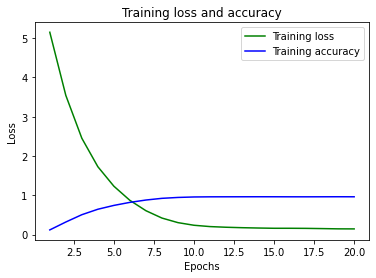

In [12]:
loss_train = model.history.history['loss']
acc_train = model.history.history['accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, acc_train, 'b', label='Training accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Text generation
Now we generate a few sentences using a random seed word and a set of various diversity (temperatures) which controls the randomness of generation. 

In [13]:
seed_index = np.random.randint(len(model.X_train+model.X_test))
seed = (model.X_train+model.X_test)[seed_index]

for diversity in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    sentence = seed
    
    for i in range(100):
        x_pred = np.zeros((1, model.MIN_SEQ))
        for t, word in enumerate(sentence):
            x_pred[0, t] = model.word_indices[word]
        preds = model.model.predict(x_pred, verbose=0)[0]
        next_index = model.sample(preds, diversity)
        next_word = model.indices_word[next_index]
        sentence = sentence[1:]
        sentence.append(next_word)
    print(sentence)

['now', 'now', 'and', 'were', 'not', 'speaking', 'and']
['youre', 'the', 'lucky', 'one', 'but', 'can', 'you']
['i', 'know', 'he', 'got', 'that', 'same', 'and']
['a', 'of', 'the', 'smile', 'you', 'didnt', 'find']
['in', 'the', 'angel', 'city', 'chasing', 'your', 'mind']
['been', 'waiting', 'for', 'king', 'of', 'my', 'heart']
['woods', 'yet', 'are', 'we', 'out', 'of', 'the']
